## PROCESS

**IMPORTING PACKAGES**->**READING AND RESIZING IMAGES(224X224)**->**ADDING IMAGES TO DATA LIST & CATEGORY TO LABELS LIST**->**ENCODING THE LABELS**

**TEST-TRAIN DATA**->**IMAGE AUGMENTATION**->**LOADING MNv2 & DOWNLOADING WEIGHT**->**HEAD MODEL**->**COMPILE - TRAIN - PREDICT - SAVE THE MODEL**

|

**IMPORTING THE REQUIRED PACKAGES**

In [15]:
import os
import numpy as np    #mathematical operations
import matplotlib.pyplot as plt
%matplotlib inline
from imutils import paths  # for performing operation on image like resizing, rotation, scaling etc
import tensorflow     # used for training and gaining inferences from our deep neural network

**IMPORTING THE DIFFERENT PROCESSING TECHNIQUES, DIFFERENT LAYERS OF OUR NEURAL NETWORK**

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

**PROVIDED WITH THE INITIAL LEARNING RATE, THE EPOCHS AND THE BATCH SIZE**

In [17]:
L_R = 1e-4
EPOCHS = 10
B_S = 32

**PROVIDING THE DIRECTORY WHERE OUR DATASET IS PRESENT ALONG WITH THE 2 CATEGORIES**

In [18]:
DIRECTORY = r"C:\Users\ankja\ML_PROJECTS\MASK_DETECTOR\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [19]:
print("WAIT_! loading images...")

WAIT_! loading images...


**HERE WE MAKE 2 LISTS**
1. For the data which contains all the arrays of the corresponding images
2. A label list which has 2 labels - with mask and without mask

In [20]:
data = []
labels = []

**CONVERTING EACH IMAGE TO A SIZE OF 224X224, THEN CONVERTING IT TO A ARRAY AND THEN APPENDING THEM TO THE LISTS**

In [21]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))    #size set to 224 x 224
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

**ENCODING THE 2 CATEGORIES**

In [22]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

**CONVERTING THE IMAGES AND THEIR LABELS TO ARRAY**

In [23]:
data = np.array(data, dtype="float32")   #this makes mobilenetv2 easy to perform predictions as it gets in the usable fromat by mobilenetv2
labels = np.array(labels)

**SPLITTING THE TRAINING AND TESTING DATA WITH 20% AS TEST DATA**

In [24]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

**CONSTRUCTING THE IMAGE GEN FOR AUGMENTING OUR DATA**

In [25]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,
                         fill_mode="nearest")

**LOADING MobileNet_V2 DOWNLOADING THE WEIGHTS**

In [26]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

**CONSTRUCTING THE HEAD OF MODEL ON THE TOP OF THE BASE MODEL**

In [27]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

**FORMING THE ACTUAL MODEL BY PLACING HEAD FC MODEL ON TOP OF BASE MODEL**

In [28]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [29]:
# loop over all layers in the base model and freeze them 
for layer in baseModel.layers:
    layer.trainable = False

**COMPILING OUR MODEL**

In [30]:
print("WAIT_! compiling model...")
opt = Adam(learning_rate=L_R, decay=L_R / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

WAIT_! compiling model...


**TRAINING OUR HEAD**

In [31]:
print("WAIT_! training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=B_S),steps_per_epoch=len(trainX) // B_S, validation_data=(testX, testY),
    validation_steps=len(testX) // B_S, epochs=EPOCHS)

WAIT_! training head...
Epoch 1/10
95/95 [==============================] - 138s 1s/step - loss: 0.3790 - accuracy: 0.8691 - val_loss: 0.1366 - val_accuracy: 0.9857
Epoch 2/10
95/95 [==============================] - 131s 1s/step - loss: 0.1434 - accuracy: 0.9641 - val_loss: 0.0727 - val_accuracy: 0.9896
Epoch 3/10
95/95 [==============================] - 122s 1s/step - loss: 0.1027 - accuracy: 0.9717 - val_loss: 0.0539 - val_accuracy: 0.9909
Epoch 4/10
95/95 [==============================] - 124s 1s/step - loss: 0.0807 - accuracy: 0.9766 - val_loss: 0.0447 - val_accuracy: 0.9909
Epoch 5/10
95/95 [==============================] - 123s 1s/step - loss: 0.0683 - accuracy: 0.9799 - val_loss: 0.0440 - val_accuracy: 0.9883
Epoch 6/10
95/95 [==============================] - 123s 1s/step - loss: 0.0553 - accuracy: 0.9855 - val_loss: 0.0367 - val_accuracy: 0.9909
Epoch 7/10
95/95 [==============================] - 122s 1s/step - loss: 0.0573 - accuracy: 0.9815 - val_loss: 0.0391 - val_accura

**PREDICTING OUR OUTPUT AND EVALUATING OUR MODEL**

In [32]:
# make predictions on the testing set
print("WAIT_! evaluating model...")
predIdxs = model.predict(testX, batch_size=B_S)

WAIT_! evaluating model...


In [33]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [34]:
# classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



**SAVING OUR MODEL**

In [35]:
# serializing the model to disk
print("WAIT_! saving mask detector model...")
model.save("facemask_detector.model", save_format="h5")

WAIT_! saving mask detector model...


D:\SOFTWARES\ANACONDA\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


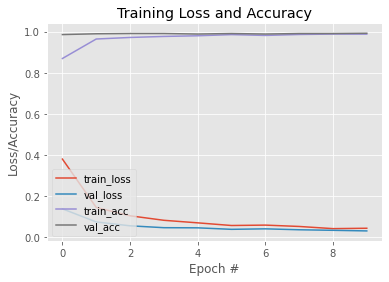

In [36]:
# plotting the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")